##Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
pip install pvlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 10.7 MB/s eta 0:00:00


In [ ]:
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##Funcionando


funciona daqui pra baixo

- Concatenar com os dados metereológicos (ok)
- Dias sem dados não está funcionando, verificar (ok)
- Adicionar os dados relacionados a posição do solar ()
  - Verificar após arrumar a principal
- Lidar com dados faltantes()
- Comparar radiação medida com céu claro (ok)
- Plotar um dia dos dados metereologicos e dados do sistema (ok)
  - Estação uma hora a frente
- Comparar dados da temperatura com os do INMET ()
  - Fazer analise descritiva
- Separar os dias de céu claro (ok)

###Montando o DataFrame

######Dados do sistema fotovoltáico

In [ ]:
valores_ausentes = [-99]
missing_day = []
df_base_pronta = pd.DataFrame()

#Leitura da pasta e identificação do nome dos arquivos
dir_station = r'/content/drive/MyDrive/ciencia_dados/aula4/CTPV/'

year = os.listdir(dir_station)


for i in year:
  dir_path = dir_station + i + '/'
  file_names = os.listdir(dir_path)

  for j in file_names:
    path = dir_path + j

    df = pd.read_csv(path, sep=';', na_values= valores_ausentes)

    #separando os dados que serão utilizados
    df["DateAndTime"] = pd.to_datetime(df["DateAndTime"])
    df_infos = df[['DateAndTime','CTPV_ReportAVG_Temp','CTPV_ReportAVG_Irrad1', 'CTPV_ReportAVG_PcaBT']]
    df_infos.columns = ['Date_Time', 'Temp', "Irrad", "Pot_BT"]

    #Filtro qualidade dos dados do dia -> Se X% da base for nan não utiliza
    if df_infos.isnull().sum().sum() > df_infos.size*0.5:
      missing_day.append(i)

    else:
      """
      df_infos['Day'] = df_infos['Date_Time'].dt.day
      df_infos['Month'] = df_infos['Date_Time'].dt.month
      df_infos['Year'] = df_infos['Date_Time'].dt.year
      df_infos['Hour'] = df_infos['Date_Time'].dt.hour
      df_infos['Minutes'] = df_infos['Date_Time'].dt.minute
      """
      df_base_pronta = pd.concat([df_infos, df_base_pronta], ignore_index=True)

#Colocando date time como index
df_base_pronta = df_base_pronta.sort_values(by = 'Date_Time')
df_base_pronta = df_base_pronta.set_index('Date_Time')

#Transformando dados de minutos para hora -> calculo por média
#dfh_sistema_mean = df_base_pronta.resample('60T').mean()


<ipython-input-5-0fa3ca182f26>:21: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DateAndTime"] = pd.to_datetime(df["DateAndTime"])
<ipython-input-5-0fa3ca182f26>:21: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DateAndTime"] = pd.to_datetime(df["DateAndTime"])
<ipython-input-5-0fa3ca182f26>:21: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DateAndTime"] = pd.to_datetime(df["DateAndTime"])
<ipython-input-5-0fa3ca182f26>:21: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DateAn

Pontos referentes ao horário

In [ ]:
#Transformando dados de minutos para hora -> calculo por média
dfh_sistema_mean = df_base_pronta.resample('60T').mean()

In [ ]:
dates = []
for i in df_base_pronta.index:
  if i.minute == 0:
    dates.append(i)

df_gerador = df_base_pronta.loc[dates]

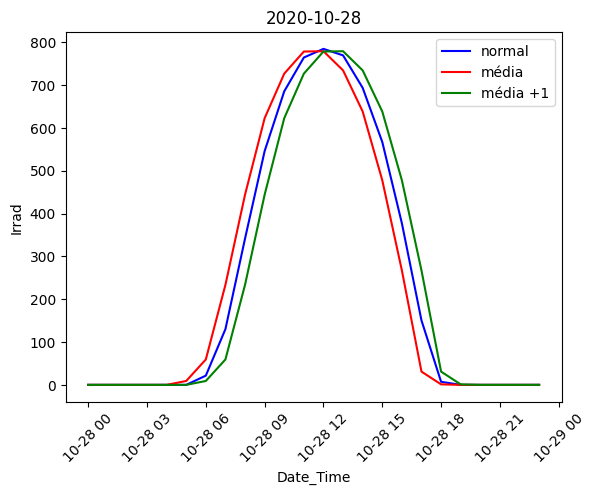

In [ ]:
dia, mes, ano = '28', '10','2020'
primeiro = '{2}-{1}-{0} 00:00:00'.format(dia,mes,ano)
segundo = '{2}-{1}-{0} 23:00:00'.format(dia,mes,ano)

fig, ax = plt.subplots()
ax= sns.lineplot(data=df_gerador[primeiro:segundo], x = df_gerador[primeiro:segundo].index, y = "Irrad", label = 'normal', color = 'b')
ax1 = sns.lineplot(data=dfh_sistema_mean[primeiro:segundo], x = dfh_sistema_mean[primeiro:segundo].index, y = 'Irrad', label = 'média', color = 'r')

df1_gerador = dfh_sistema_mean.copy()
df1_gerador.index = df1_gerador.index + datetime.timedelta(hours = 1)
ax2 = sns.lineplot(data=df1_gerador[primeiro:segundo], x = df1_gerador[primeiro:segundo].index, y = 'Irrad', label = 'média +1', color = 'g')

plt.xticks(rotation = 45)
plt.title('{2}-{1}-{0}'.format(dia,mes,ano))
plt.show()

**Integral**

* Calcula a média entre 00:30 e 01:29
* O resultado é referente ao horário 01:00

In [ ]:
def integral_ponto_medio(k):

  xdf = pd.DataFrame()

  primeiro = k.index[0] + datetime.timedelta(minutes = 30)
  segundo = primeiro + datetime.timedelta(hours = 1) - datetime.timedelta(minutes=1)
  limite = k.index[len(k.index)-1] - datetime.timedelta(minutes = 30)

  while primeiro < limite:

    dic = {'Date_Time': [(primeiro + datetime.timedelta(minutes = 30))],
          'Temp': [k.loc[primeiro:segundo].mean()[0]],
          'Irrad': [k.loc[primeiro:segundo].mean()[1]],
          'Pot_BT': [k.loc[primeiro:segundo].mean()[2]]}

    xdf = pd.concat([xdf, pd.DataFrame(dic)], ignore_index = True)

    primeiro += datetime.timedelta(hours = 1)
    segundo += datetime.timedelta(hours = 1)

  xdf.set_index('Date_Time', inplace = True)

  return xdf

In [ ]:
df_teste = integral_ponto_medio(df_base_pronta)

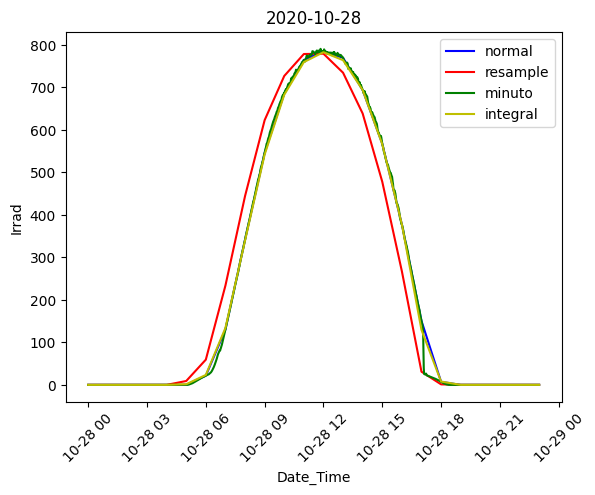

In [ ]:
#28/10/2020
dia, mes, ano = '28', '10','2020'
primeiro = '{2}-{1}-{0} 00:00:00'.format(dia,mes,ano)
segundo = '{2}-{1}-{0} 23:00:00'.format(dia,mes,ano)

fig, ax = plt.subplots()
ax= sns.lineplot(data=df_gerador[primeiro:segundo], x = df_gerador[primeiro:segundo].index, y = "Irrad", label = 'normal', color = 'b')
ax1 = sns.lineplot(data=dfh_sistema_mean[primeiro:segundo], x = dfh_sistema_mean[primeiro:segundo].index, y = 'Irrad', label = 'resample', color = 'r')
ax2 = sns.lineplot(data=df_base_pronta[primeiro:segundo], x = df_base_pronta[primeiro:segundo].index, y = 'Irrad', label = 'minuto', color = 'g')
ax3= sns.lineplot(data=df_teste[primeiro:segundo], x = df_teste[primeiro:segundo].index, y = "Irrad", label = 'integral', color = 'y')

plt.xticks(rotation = 45)
plt.title('{2}-{1}-{0}'.format(dia,mes,ano))
plt.show()

In [ ]:
def filtro (df_func, target, acao = 'drop'):
  #Separando a base de dados
  df_datas = df_func[['Day', 'Month', 'Year']].drop_duplicates().reset_index(drop = True)
  investiga = []

  for i in range (0, len(df_datas)):

    #ajustando dados para identificação do periodo
    dia = df_datas['Day'][i]
    mes = df_datas['Month'][i]
    ano = df_datas['Year'][i]
    if dia < 10:
      dia = '0' + str(dia)
    if mes < 10:
      mes = '0' + str(mes)

    #Identificando os dados pertencentes do dia que será analisado
    primeiro = '{2}-{1}-{0} 00:00:00'.format(dia, mes, ano)
    segundo = '{2}-{1}-{0} 23:00:00'.format(dia, mes, ano)
    avalia = df_func.loc[(df_func['Date_Time'] >= primeiro) &
                              (df_func['Date_Time'] <= segundo)]

    ava_2 = avalia[target].loc[(avalia[target] > 0) & ((avalia['Hour'] < 5) | (avalia['Hour'] > 19))].value_counts()
    ava = avalia[target].value_counts()

    #se há mais que 10 dados diferentes entra no investiga
    if (len(ava) < 10) | (len(ava_2) != 0):
      investiga.append(primeiro)
      investiga.append(segundo)
    else:
      pass



  #_________________________

  if acao == 'plot':

    #Criando o local para plotar os dados
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.9, wspace=0.3, bottom = 0.1)
    fig.set_figheight(150)
    fig.set_figwidth(20)

    #contador de gráficos
    j=0

    for i in range(0, len(investiga), 2):
      #identifica os dados que serão plotados
      df_investiga = df_func.loc[(df_func['Date_Time'] >= investiga[i]) & (df_func['Date_Time'] <= investiga[i + 1])]

      #só entra as datas que contém dados
      if len(df_investiga.value_counts()) != 0:

        #Plot dos dados da potencia
        j += 1
        ax = fig.add_subplot(100, 4, j)
        ax = sns.lineplot(data = df_investiga,
                    x = "Hour",
                    y = "Pot_BT",
                    label = 'Potência',
                    color = 'b')
        plt.title(investiga[i])

        #Plot ao lado os dados da irradiação do sistema e da estação
        j += 1
        ax = fig.add_subplot(100, 4, j)
        ax = sns.lineplot(data = df_investiga,
                    x = "Hour",
                    y = "Irrad",
                    label = 'Sistema',
                    color = 'b')
        #ax1 = sns.lineplot(data = df_investiga,
        #            x = "Hour",
        #            y = 'Irradiação Global horária(Inclinada 27°) kWh/m2',
        #            label = "Estação",
        #            color = 'r')
        plt.title(investiga[i])

    return plt.show()

  elif acao == 'drop':
      # Coletar todos os índices para serem excluídos
      indices_a_excluir = []
      for i in range(0, len(investiga), 2):
          indices = df_func.loc[(df_func['Date_Time'] >= investiga[i]) & (df_func['Date_Time'] <= investiga[i + 1])].index
          indices_a_excluir.extend(indices)

      # Excluir todos os índices coletados
      df_func.drop(indices_a_excluir, inplace=True)

      df_func = df_func.reset_index(drop=True)
      return df_func

In [ ]:
df_teste['Day'] = df_teste.index.day
df_teste['Month'] = df_teste.index.month
df_teste['Year'] = df_teste.index.year
df_teste['Hour'] = df_teste.index.hour
df_teste = df_teste.drop_duplicates()

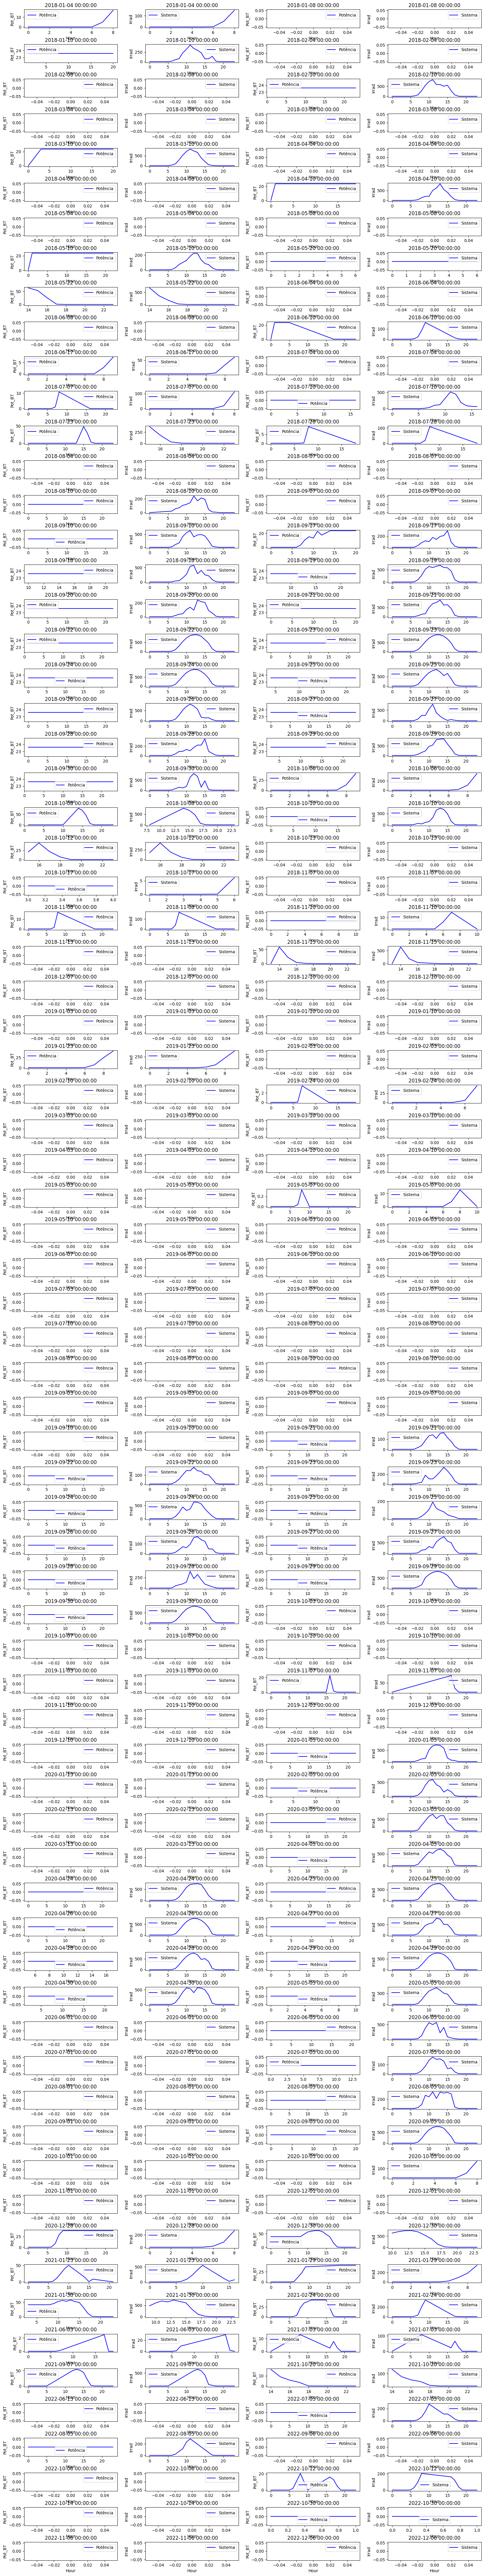

In [ ]:
filtro(df_teste.reset_index(), 'Pot_BT', acao = 'plot')

In [ ]:
df_filtro = filtro(df_teste.reset_index(), 'Pot_BT', acao = 'drop')
df_filtro.set_index('Date_Time', inplace = True)
df_filtro.drop(columns = ['Day', 'Month', 'Year', 'Hour'], inplace = True)
df_filtro

,Temp,Irrad,Pot_BT
Date_Time,,,
2018-01-01 01:00:00,21.192317,0.000000,0.0000
2018-01-01 02:00:00,20.595667,0.000000,0.0000
2018-01-01 03:00:00,20.153217,0.000000,0.0000
2018-01-01 04:00:00,19.970350,0.000000,0.0000
2018-01-01 05:00:00,19.950350,0.586733,0.0000
...,...,...,...
2022-12-31 19:00:00,23.420667,5.517450,0.0578
2022-12-31 20:00:00,21.706517,0.000000,0.0000
2022-12-31 21:00:00,19.963000,0.000000,0.0000


######Dados metereológicos

In [ ]:
valores_ausentes = [-99]
url = "/content/drive/MyDrive/ciencia_dados/aula4/Matriz_101_2015_a_2021.xlsx"
df = pd.read_excel(url, na_values= valores_ausentes)
df.drop(columns = ['Matriz', 'Ano', "Dia Juliano",
                   'Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16'], inplace = True)

#Transformando os dados de Horas XXXX em XX
df = df.astype({'Hora':'str'})
df['Hora'].replace('00', '', regex=True, inplace = True)

#Tranformando horário 24 em 00 e passando o dia para manter o padrão
df["Data"] = np.where((df['Hora']=='24'), df['Data']+ datetime.timedelta(days = 1),df['Data'])
df['Hora'].replace('24', '00', regex=True, inplace = True)

#Criando coluna date_time e transformando em index
df = df.astype({'Data':'str'})
df['Date_Time'] = df['Data'] + ' ' + df['Hora'] + ":00:00"
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df.drop(columns=['Data', 'Hora'], inplace = True)
df = df.set_index('Date_Time')

#df.index = df.index - datetime.timedelta(hours = 1)

#2022
valores_ausentes = [-99]
url = "/content/drive/MyDrive/ciencia_dados/aula4/Matriz_101_2022.xlsx"
df_1 = pd.read_excel(url, na_values= valores_ausentes)
df_1.drop(columns = ['Matriz', 'Ano', "Dia Juliano",
                   'Observações','PD (%)'], inplace = True)
df_1.dropna(inplace=True)
df_1.drop(df_1['Irradiação Global horária(horizontal) kWh/m2'].loc[df_1['Irradiação Global horária(horizontal) kWh/m2']=='!!Dados Perdidos'].index, inplace =True)
df_1.drop(3427,inplace = True)
#Transformando os dados de Horas XXXX em XX
df_1 = df_1.astype({'Hora':'str',
                    'Irradiação Global horária(horizontal) kWh/m2':'float',
                    'Irradiação Difusa horária           kWh/m2':'float',
                    'Irradiação Global horária(Inclinada 27°) kWh/m2':'float',
                    'Temperatura ambiente     °C':'float',
                    'Umidade Relativa %':'float',
                    'Velocidade média do vento       m/s':'float',
                    'Pressão Baromêtrica mm Hg':'float',
                    'Pluviômetro mm ':'float',})
df_1['Data'] = pd.to_datetime(df_1['Data'])

df_1['Hora'].replace('00', '', regex=True, inplace = True)

#Tranformando horário 24 em 00 e passando o dia para manter o padrão
df_1["Data"] = np.where((df_1['Hora']=='24'), df_1['Data']+ datetime.timedelta(days = 1),df_1['Data'])
df_1['Hora'].replace('24', '00', regex=True, inplace = True)

#Criando coluna date_time e transformando em index
df_1 = df_1.astype({'Data':'str'})
df_1['Date_Time'] = df_1['Data'] + ' ' + df_1['Hora'] + ":00:00"
df_1['Date_Time'] = pd.to_datetime(df_1['Date_Time'])
df_1.drop(columns=['Data', 'Hora'], inplace = True)
df_1 = df_1.set_index('Date_Time')

df_1.columns = df.columns

df = pd.concat([df, df_1])

Validação do ajuste dos dados


In [ ]:
df

,Irradiação Global horária(horizontal) kWh/m2,Irradiação Difusa horária kWh/m2,Irradiação Global horária(Inclinada 27°) kWh/m2,Temperatura ambiente °C,Umidade Relativa %,Velocidade média do vento m/s,Pressão Baromêtrica mm Hg,Pluviômetro mm
Date_Time,,,,,,,,
2015-06-11 18:00:00,0.0,0.0,0.0,14.46,63.08,0.088,616.80,0.0
2015-06-11 19:00:00,0.0,0.0,0.0,23.48,61.13,0.003,595.90,0.0
2015-06-11 20:00:00,0.0,0.0,0.0,29.71,59.79,0.000,576.90,0.0
2015-06-11 21:00:00,0.0,0.0,0.0,31.04,59.49,0.000,563.70,0.0
2015-06-11 22:00:00,0.0,0.0,0.0,30.71,59.50,0.000,554.70,0.0
...,...,...,...,...,...,...,...,...
2022-12-31 20:00:00,0.0,0.0,0.0,21.52,88.40,0.002,700.66,0.0
2022-12-31 21:00:00,0.0,0.0,0.0,20.54,92.60,0.001,700.71,0.0
2022-12-31 22:00:00,0.0,0.0,0.0,19.83,95.20,0.000,700.83,0.0


In [ ]:
valores_ausentes = [-99]
url = "/content/drive/MyDrive/ciencia_dados/aula4/Matriz_101_2015_a_2021.xlsx"
k = pd.read_excel(url, na_values= valores_ausentes)
k.drop(columns = ['Matriz', 'Ano', "Dia Juliano",
                   'Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16'], inplace = True)

In [ ]:
x = k[['Irradiação Global horária(horizontal) kWh/m2','Irradiação Global horária(Inclinada 27°) kWh/m2','Hora']].loc[k['Data'] == '2020-10-28']*1000
x.set_index('Hora')

,Irradiação Global horária(horizontal) kWh/m2,Irradiação Global horária(Inclinada 27°) kWh/m2
Hora,,
100000,0.0,0.0
200000,0.0,0.0
300000,0.0,0.0
400000,0.0,0.0
500000,0.0,0.0
600000,13.0,11.0
700000,220.0,111.0
800000,470.0,338.0
900000,700.0,570.0


In [ ]:
df[['Irradiação Global horária(horizontal) kWh/m2','Irradiação Global horária(Inclinada 27°) kWh/m2']].loc[primeiro:segundo]*1000

,Irradiação Global horária(horizontal) kWh/m2,Irradiação Global horária(Inclinada 27°) kWh/m2
Date_Time,,
2020-10-28 00:00:00,0.0,0.0
2020-10-28 01:00:00,0.0,0.0
2020-10-28 02:00:00,0.0,0.0
2020-10-28 03:00:00,0.0,0.0
2020-10-28 04:00:00,0.0,0.0
2020-10-28 05:00:00,0.0,0.0
2020-10-28 06:00:00,13.0,11.0
2020-10-28 07:00:00,220.0,111.0
2020-10-28 08:00:00,470.0,338.0


Analise gráfica com o gerador

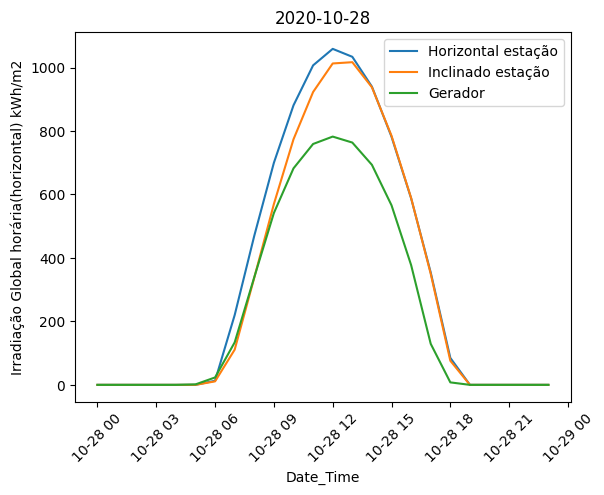

In [ ]:
#28/10/2020
dia, mes, ano = '28', '10','2020'
primeiro = '{2}-{1}-{0} 00:00:00'.format(dia,mes,ano)
segundo = '{2}-{1}-{0} 23:00:00'.format(dia,mes,ano)

fig, ax = plt.subplots()

ax1 = sns.lineplot(data = df['Irradiação Global horária(horizontal) kWh/m2'].loc[primeiro:segundo]*1000, label = 'Horizontal estação')
ax2 = sns.lineplot(data = df['Irradiação Global horária(Inclinada 27°) kWh/m2'].loc[primeiro:segundo]*1000, label = 'Inclinado estação')
ax3 = sns.lineplot(data = df_teste['Irrad'].loc[primeiro:segundo], label = 'Gerador')

plt.xticks(rotation = 45)
plt.title('{2}-{1}-{0}'.format(dia,mes,ano))
plt.show()

In [ ]:
"""
x = df.loc[(df.index >= '2020-07-04 00:00:00') & ((df.index <= '2020-07-04 23:59:00'))] #2019-12-07
(x[['Irradiação Global horária(horizontal) kWh/m2','Irradiação Global horária(Inclinada 27°) kWh/m2']])
sns.lineplot(data = x[['Irradiação Global horária(horizontal) kWh/m2']])
"""

"\nx = df.loc[(df.index >= '2020-07-04 00:00:00') & ((df.index <= '2020-07-04 23:59:00'))] #2019-12-07\n(x[['Irradiação Global horária(horizontal) kWh/m2','Irradiação Global horária(Inclinada 27°) kWh/m2']])\nsns.lineplot(data = x[['Irradiação Global horária(horizontal) kWh/m2']])\n"

######Posição solar

In [ ]:
lat, lon = -23.56, -46.74
times = pd.date_range(df.index[0], df.index[len(df)-1], freq='H',tz = 'America/Sao_Paulo')
loc = Location(latitude=lat, longitude=lon, altitude = 760, tz = 'America/Sao_Paulo')

In [ ]:
sp = loc.get_solarposition(times)
sp = sp.tz_localize(None)

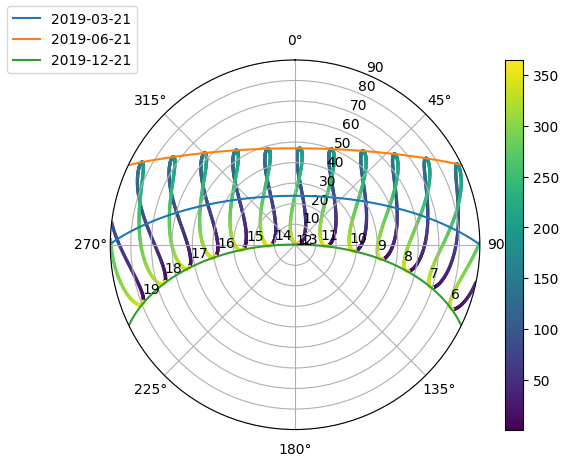

In [ ]:
solpos = sp['2019-01-01 00:00:00':'2019-12-31']
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

ax = plt.subplot(1, 1, 1, projection='polar')
# draw the analemma loops
points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith,
                    s=2, label=None, c=solpos.index.dayofyear)
ax.figure.colorbar(points)

# draw hour labels
for hour in np.unique(solpos.index.hour):
    # choose label position by the smallest radius for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    r = subset.apparent_zenith
    pos = solpos.loc[r.idxmin(), :]
    ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))

# draw individual days
for date in pd.to_datetime(['2019-03-21', '2019-06-21', '2019-12-21']):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz='America/Sao_Paulo')
    solpos = solarposition.get_solarposition(times, lat, lon)
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    label = date.strftime('%Y-%m-%d')
    ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=label)

ax.figure.legend(loc='upper left')

# change coordinates to be like a compass
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.show()

######Modelo de céu claro

https://pvlib-python.readthedocs.io/en/stable/user_guide/clearsky.html#ineichen-and-perez

In [ ]:
lat, lon = -23.56, -46.74
times = pd.date_range(df_teste.index[0], df_teste.index[len(df_teste)-1], freq='min',tz = 'America/Sao_Paulo')
loc = Location(latitude=lat, longitude=lon, altitude = 760, tz = 'America/Sao_Paulo')

In [ ]:
"""
altitude = 760
zenith_aparente = sp['apparent_zenith']
massa_ar = pvlib.atmosphere.get_relative_airmass(zenith_aparente)
pressao = pvlib.atmosphere.alt2pres(altitude)
linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon).tz_localize(None)
dni_extra = pvlib.irradiance.get_extra_radiation(times).tz_localize(None)
cs = clearsky.ineichen(zenith_aparente, massa_ar, linke_turbidity, altitude, dni_extra)
"""

"\naltitude = 760\nzenith_aparente = sp['apparent_zenith']\nmassa_ar = pvlib.atmosphere.get_relative_airmass(zenith_aparente)\npressao = pvlib.atmosphere.alt2pres(altitude)\nlinke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon).tz_localize(None)\ndni_extra = pvlib.irradiance.get_extra_radiation(times).tz_localize(None)\ncs = clearsky.ineichen(zenith_aparente, massa_ar, linke_turbidity, altitude, dni_extra)\n"

In [ ]:
cs = loc.get_clearsky(times)
cs=cs.tz_localize(None)
cs_teste = cs.resample('H', label = 'right').mean()
cs_teste = cs_teste.replace([np.nan, np.inf, -np.inf], 0)

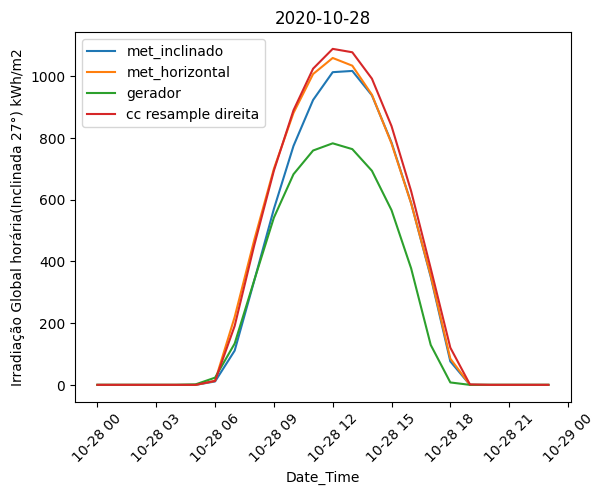

In [ ]:
dia, mes, ano = '28', '10','2020'
primeiro = '{2}-{1}-{0} 00:00:00'.format(dia,mes,ano)
segundo = '{2}-{1}-{0} 23:00:00'.format(dia,mes,ano)

fig, ax = plt.subplots()

ax = sns.lineplot(data = df['Irradiação Global horária(Inclinada 27°) kWh/m2'].loc[primeiro:segundo]*1000, label = 'met_inclinado')
ax1 = sns.lineplot(data = df['Irradiação Global horária(horizontal) kWh/m2'].loc[primeiro:segundo]*1000, label = 'met_horizontal')
#ax2 = sns.lineplot(data = cs['ghi'].loc[primeiro:segundo], label = 'céu claro')
ax3 = sns.lineplot(data = df_filtro['Irrad'].loc[primeiro:segundo], label = 'gerador')
#ax4 = sns.lineplot(data = cs_teste['ghi'].loc[primeiro:segundo], label = 'céu claro teste')
ax4 = sns.lineplot(data = cs_teste['ghi'].loc[primeiro:segundo], label = 'cc resample direita')

plt.xticks(rotation = 45)
plt.title('{2}-{1}-{0}'.format(dia,mes,ano))
plt.show()

In [ ]:
x = pd.DataFrame(cs_teste['ghi'].loc[primeiro:segundo])
x['Irrad'] = df_teste['Irrad'].loc[primeiro:segundo]
x['horiz'] = df['Irradiação Global horária(horizontal) kWh/m2'].loc[primeiro:segundo]*1000
x['incli'] = df['Irradiação Global horária(Inclinada 27°) kWh/m2'].loc[primeiro:segundo]*1000
x['2020-10-28 05:00:00':'2020-10-28 19:00:00']

NameError: name 'pd' is not defined

Se trazer os dados da estação metereológica 30 minutos para o passado, o comportamento da curva fica parecido com o modelo de céu claro, mas o pico do 12:00 não

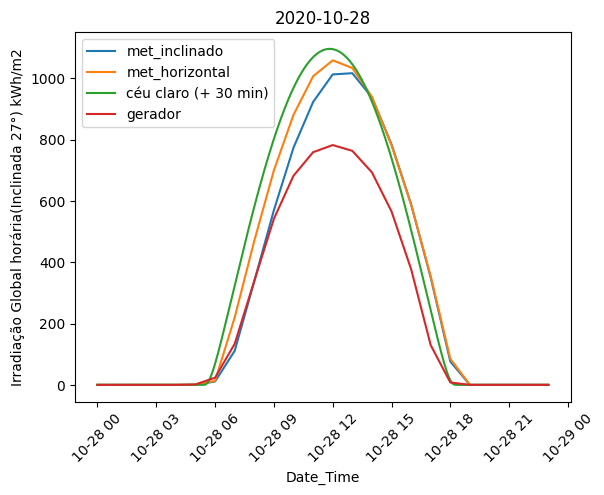

In [ ]:
dia, mes, ano = '28', '10','2020'
primeiro = '{2}-{1}-{0} 00:00:00'.format(dia,mes,ano)
segundo = '{2}-{1}-{0} 23:00:00'.format(dia,mes,ano)

fig, ax = plt.subplots()

a = df.loc[primeiro:segundo]*1000
#c = cs.loc[primeiro:segundo]
#c.index = c.index + datetime.timedelta(minutes = 30)

ax = sns.lineplot(data = a['Irradiação Global horária(Inclinada 27°) kWh/m2'], label = 'met_inclinado')

ax1 = sns.lineplot(data = a['Irradiação Global horária(horizontal) kWh/m2'], label = 'met_horizontal')

ax2 = sns.lineplot(data = cs['ghi'].loc[primeiro:segundo], label = 'céu claro (+ 30 min)')

ax3 = sns.lineplot(data = df_teste['Irrad'].loc[primeiro:segundo], label = 'gerador')

plt.xticks(rotation = 45)
plt.title('{2}-{1}-{0}'.format(dia,mes,ano))
plt.show()

######Junção das planilhas

In [ ]:
lat, lon = -23.56, -46.74
times = pd.date_range(df.index[0], df.index[len(df)-1], freq='H',tz = 'America/Sao_Paulo')
loc = Location(latitude=lat, longitude=lon, altitude = 760, tz = 'America/Sao_Paulo')
dni_extra = pvlib.irradiance.get_extra_radiation(times).tz_localize(None)

#Junção das planilhas
df_join = sp.join([df_filtro,cs_teste,df,pd.DataFrame(dni_extra)])

#Separação de alguns dados utilizados futuramente
df_join.reset_index(inplace = True)
df_join.rename(columns = {'index': 'Date_Time',0: 'Extra Radiation'}, inplace = True)
df_join['Day'] = df_join['Date_Time'].dt.day
df_join['Month'] = df_join['Date_Time'].dt.month
df_join['Year'] = df_join['Date_Time'].dt.year
df_join['Minutes'] = df_join['Date_Time'].dt.minute
df_join['Hour'] = df_join['Date_Time'].dt.hour
df_join.set_index('Date_Time', inplace = True)

#Transformando os dados de irradiação em wh/m2
df_join ['Irradiação Global horária(horizontal) kWh/m2'] *= 1000
df_join ['Irradiação Difusa horária kWh/m2'] *= 1000
df_join ['Irradiação Global horária(Inclinada 27°) kWh/m2'] *= 1000


df_join['k'] = pvlib.irradiance.clearness_index(df_join['Irradiação Global horária(horizontal) kWh/m2'], df_join['zenith'], df_join['Extra Radiation']) #G_estação/G_extraterrestre
df_join['k*'] = pvlib.irradiance.clearsky_index(df_join['Irradiação Global horária(horizontal) kWh/m2'], df_join['ghi']) #G_estação/G_modelo


df_join.drop_duplicates(inplace = True)
df_join

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,Temp,Irrad,Pot_BT,ghi,...,Pressão Baromêtrica mm Hg,Pluviômetro mm,Extra Radiation,Day,Month,Year,Minutes,Hour,k,k*
Date_Time,,,,,,,,,,,,,,,,,,,,,
2015-06-11 18:00:00,97.617949,97.617949,-7.617949,-7.617949,291.936293,0.353117,NaN,NaN,NaN,NaN,...,616.80,0.0,1323.953150,11,6,2015,0,18,0.0,NaN
2015-06-11 19:00:00,110.579155,110.579155,-20.579155,-20.579155,287.073010,0.344579,NaN,NaN,NaN,NaN,...,595.90,0.0,1323.953150,11,6,2015,0,19,0.0,NaN
2015-06-11 20:00:00,123.859937,123.859937,-33.859937,-33.859937,282.888097,0.336034,NaN,NaN,NaN,NaN,...,576.90,0.0,1323.953150,11,6,2015,0,20,0.0,NaN
2015-06-11 21:00:00,137.353627,137.353627,-47.353627,-47.353627,279.128355,0.327483,NaN,NaN,NaN,NaN,...,563.70,0.0,1323.953150,11,6,2015,0,21,0.0,NaN
2015-06-11 22:00:00,150.986471,150.986471,-60.986471,-60.986471,275.552791,0.318925,NaN,NaN,NaN,NaN,...,554.70,0.0,1323.953150,11,6,2015,0,22,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 20:00:00,103.452849,103.452849,-13.452849,-13.452849,237.088021,-3.167663,21.706517,0.0,0.0,0.0,...,700.66,0.0,1413.940576,31,12,2022,0,20,0.0,0.0
2022-12-31 21:00:00,114.397814,114.397814,-24.397814,-24.397814,228.196151,-3.187402,19.963000,0.0,0.0,0.0,...,700.71,0.0,1413.940576,31,12,2022,0,21,0.0,0.0
2022-12-31 22:00:00,123.691327,123.691327,-33.691327,-33.691327,216.508829,-3.207132,19.887783,0.0,0.0,0.0,...,700.83,0.0,1413.940576,31,12,2022,0,22,0.0,0.0


In [ ]:
df_join.loc[df_join['Year']>2017].isnull().sum()

apparent_zenith                                        0
zenith                                                 0
apparent_elevation                                     0
elevation                                              0
azimuth                                                0
equation_of_time                                       0
Temp                                               10137
Irrad                                              10137
Pot_BT                                             10057
ghi                                                    2
dni                                                    2
dhi                                                    2
Irradiação Global horária(horizontal) kWh/m2         241
Irradiação Difusa horária kWh/m2                     241
Irradiação Global horária(Inclinada 27°) kWh/m2      241
Temperatura ambiente °C                              241
Umidade Relativa %                                   241
Velocidade média do vento m/s  

In [ ]:
df_join.isnull().sum()

apparent_zenith                                        0
zenith                                                 0
apparent_elevation                                     0
elevation                                              0
azimuth                                                0
equation_of_time                                       0
Temp                                               32558
Irrad                                              32558
Pot_BT                                             32478
ghi                                                22423
dni                                                22423
dhi                                                22423
Irradiação Global horária(horizontal) kWh/m2         248
Irradiação Difusa horária kWh/m2                     248
Irradiação Global horária(Inclinada 27°) kWh/m2      248
Temperatura ambiente °C                              248
Umidade Relativa %                                   248
Velocidade média do vento m/s  

In [ ]:
df_join.to_csv('/content/drive/MyDrive/mestrado/dados mestrado/base_teste.csv')

In [ ]:
df_join = df_join[['Irradiação Global horária(Inclinada 27°) kWh/m2',
                 'Temperatura ambiente °C',
                 'Umidade Relativa %',
                 'Velocidade média do vento m/s',
                 'zenith',
                 'azimuth']].loc[df_join['Year']>2018]
#df_join = df_join.drop_duplicates(subset = ['Date_Time'])
df_join.to_csv('/content/drive/MyDrive/mestrado/dados mestrado/dados_ae.csv')

<ipython-input-41-df17de6fd5c7>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(meses_ptbr)


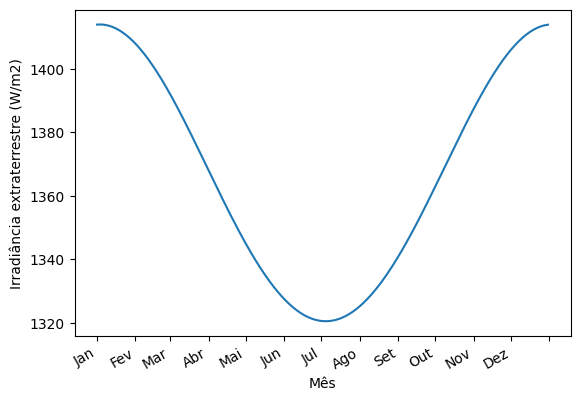

In [ ]:
lat, lon = -23.56, -46.74
times = pd.date_range("01-01-2021", "31-12-2021", freq='D',tz = 'America/Sao_Paulo')
loc = Location(latitude=lat, longitude=lon, altitude = 760, tz = 'America/Sao_Paulo')
dni_extra = pvlib.irradiance.get_extra_radiation(times).tz_localize(None)
import matplotlib.dates as mdates
sns.lineplot(data= dni_extra)
# Definir os nomes dos meses em português
meses_ptbr = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Configurar os rótulos do eixo x para mostrar os meses em português
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_xticklabels(meses_ptbr)

# Adicionar rótulos e título
plt.xlabel('Mês')
plt.ylabel('Irradiância extraterrestre (W/m2)')
#plt.title('Valores ao longo de 2021')

# Rotacionar os rótulos do eixo x para uma melhor visualização, se necessário
plt.gcf().autofmt_xdate()

# Mostrar o gráfico
plt.show()

In [ ]:
dni_extra

2021-01-01    1413.981805
2021-01-02    1414.008017
2021-01-03    1414.019201
2021-01-04    1414.015353
2021-01-05    1413.996473
                 ...     
2021-12-27    1413.625893
2021-12-28    1413.726975
2021-12-29    1413.813137
2021-12-30    1413.884347
2021-12-31    1413.940576
Length: 365, dtype: float64

######Avaliando modelo de céu claro com a estação metereológica

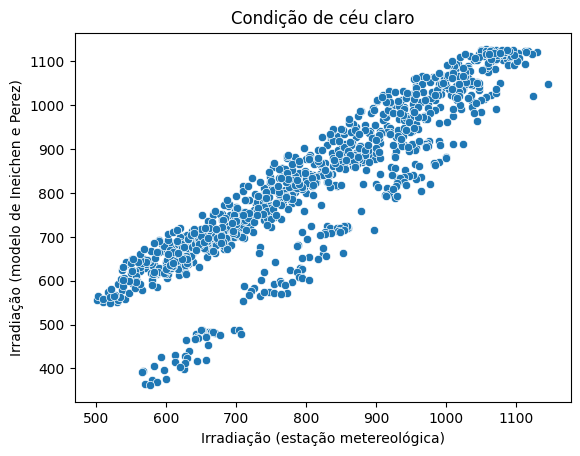

ValueError: Input contains NaN.

In [ ]:
from sklearn.metrics import mean_squared_error

x = df_join[['Irradiação Global horária(horizontal) kWh/m2','ghi','Hour']].loc[(df_join['k']>0.75) & (df_join['zenith']<70) ]

sns.scatterplot(data = df_join[['Irradiação Global horária(horizontal) kWh/m2','ghi']].loc[(df_join['k']>0.75) & (df_join['zenith']<60)],
                x = 'Irradiação Global horária(horizontal) kWh/m2',
                y = 'ghi')
plt.title('Condição de céu claro')
plt.xlabel('Irradiação (estação metereológica)')
plt.ylabel('Irradiação (modelo de Ineichen e Perez)')
plt.show()

rmse = np.sqrt(mean_squared_error(x['Irradiação Global horária(horizontal) kWh/m2'], x['ghi']))
bias = np.mean(x['ghi']) - np.mean(x['Irradiação Global horária(horizontal) kWh/m2'])

print("\nBias:      ", bias)
print("RMSE:       ", rmse)
print("Média:      ", np.mean(x['Irradiação Global horária(horizontal) kWh/m2']))
print("Bias/Média:", bias/np.mean(x['Irradiação Global horária(horizontal) kWh/m2']))

x[['Irradiação Global horária(horizontal) kWh/m2','ghi']].corr()

In [ ]:
x['Hour'].value_counts()

15    230
14    173
16    151
13    138
12     86
11     52
10     46
9      42
8      17
17     16
Name: Hour, dtype: int64

######Exportando o Data Frame


In [ ]:
df_join = df_join.loc[df_join['Year']>=2018]
df_join = df_join.drop_duplicates(subset = ['Date_Time'])

In [ ]:
df_join.loc[df_join.duplicated() == True]

,Date_Time,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,Temp,Irrad,Pot_BT,...,Pressão Baromêtrica mm Hg,Pluviômetro mm,Extra Radiation,Day,Month,Year,Minutes,Hour,k,k*


In [ ]:
y = df_join.loc[(df_join['Year'] >= 2018) & (df_join['Year'] <= 2019)]
print(y.count())
y[['Month','Year']].value_counts()

Date_Time                                          11351
apparent_zenith                                    11351
zenith                                             11351
apparent_elevation                                 11351
elevation                                          11351
azimuth                                            11351
equation_of_time                                   11351
Temp                                               11256
Irrad                                              11256
Pot_BT                                             11262
ghi                                                11351
dni                                                11351
dhi                                                11351
Irradiação Global horária(horizontal) kWh/m2       11351
Irradiação Difusa horária kWh/m2                   11351
Irradiação Global horária(Inclinada 27°) kWh/m2    11351
Temperatura ambiente °C                            11351
Umidade Relativa %             

Month  Year
12     2018    672
3      2018    648
1      2018    624
       2019    624
8      2019    624
4      2018    624
       2019    624
7      2019    624
5      2019    624
8      2018    600
6      2018    600
       2019    600
5      2018    576
11     2018    551
2      2018    528
       2019    456
9      2019    360
7      2018    264
9      2018    264
3      2019    192
12     2019    192
10     2019    168
11     2019    168
10     2018    144
dtype: int64

In [ ]:
y = df_join.loc[(df_join['Year'] == 2021)]
print(y.count())
y[['Month','Year']].value_counts()

Date_Time                                          8568
apparent_zenith                                    8568
zenith                                             8568
apparent_elevation                                 8568
elevation                                          8568
azimuth                                            8568
equation_of_time                                   8568
Temp                                               8474
Irrad                                              8474
Pot_BT                                             8536
ghi                                                8568
dni                                                8568
dhi                                                8568
Irradiação Global horária(horizontal) kWh/m2       8568
Irradiação Difusa horária kWh/m2                   8568
Irradiação Global horária(Inclinada 27°) kWh/m2    8568
Temperatura ambiente °C                            8568
Umidade Relativa %                              

Month  Year
3      2021    744
5      2021    744
8      2021    744
12     2021    744
4      2021    720
7      2021    720
10     2021    720
11     2021    720
6      2021    696
9      2021    696
1      2021    672
2      2021    648
dtype: int64

In [ ]:
y_train.index[0]

NameError: ignored

In [ ]:
x = df_join.loc[df_join['Year'] == 2022]
x.set_index('Date_Time', inplace = True)

n_past = 24
n_future = 1
input_tag = ['Irradiação Global horária(Inclinada 27°) kWh/m2',
             'Temperatura ambiente °C',
             'Umidade Relativa %',
             'Velocidade média do vento m/s',
             'zenith',
             'azimuth']

treino = x[n_past:len(x) - n_past]
y_train = treino['Pot_BT'].loc[(treino['zenith'] < 80) & (treino['Pot_BT'].isnull() == False)]
y_train /= 156

x_train = []
ytreino = []
ytreino = []

for i in y_train.index:
    if (np.isnan(x['Pot_BT'].loc[i + datetime.timedelta(hours=n_future-1)]) == False):
        if len(x[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)]) == n_past:
          ytreino.append(x['Pot_BT'].loc[i + datetime.timedelta(hours=n_future-1)])
          x_train.append(x[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)])

x_train, y_train = np.array(x_train), np.array(y_train)
ytreino =np.array(ytreino)

In [ ]:
c = 0
for i in x_train:
  c+=1
  if i.shape[0] != 24:
    print(i.index[0])
    print(i.shape)
    print(c, '\n')

In [ ]:
len(treino[input_tag].loc[pd.to_datetime('2022-01-31 00:00:00')- datetime.timedelta(hours = n_past) : pd.to_datetime('2022-01-31 00:00:00')- datetime.timedelta(hours = 1)]) == n_past

In [ ]:
x.isnull().sum()

In [ ]:

df_join.to_csv('/content/drive/MyDrive/mestrado/dados mestrado/dados.csv')

In [ ]:
df_join.loc[df_join['Date_Time'] == '2022-08-08 11:00:00']

In [ ]:
df_join = df_join[['Irradiação Global horária(Inclinada 27°) kWh/m2',
             'Temperatura ambiente °C',
             'Umidade Relativa %',
             'Velocidade média do vento m/s',
             'zenith',
             'azimuth',
             'Extra Radiation']].loc[df_join['Year']<2018]
df_join.to_csv('/content/drive/MyDrive/mestrado/dados mestrado/dados_ae.csv')